
# MCM 项目：图像评分模型与验证 (Image Scoring Model & Validation)
**多模态数据融合 - 图像分析模块**

本 Notebook 实现了基于新整理的 **"真" (Asian Giant Hornet)** 和 **"假" (Vespa Crabro/Other)** 数据集的图像评分机制。
我们摒弃了简单的重心距离模型，转而使用 **逻辑回归 (Logistic Regression)** 概率分类器，以提供具有统计学意义的 0-1 置信度分数。

**核心指标 (Key Metrics):**
1.  **KS 统计量 (KS Statistic)**: 用于衡量正负样本分布分离程度的关键指标。KS 值越大，模型区分真假的能力越强。
2.  **得分分布 (Score Distribution)**: 通过可视化直方图展示真假样本在得分空间上的重叠情况。


In [3]:

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import stats

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
# 尝试设置中文字体，如果失败则回退到默认字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False



## 1. 特征提取方法 (Feature Extraction Methodology)
我们沿用 `image_feature_extraction.py` 中定义的可解释手工特征：
*   **GLCM (纹理特征)**: 对比度 (Contrast), 能量 (Energy), 相关性 (Correlation), 熵 (Entropy) (16级量化)。
*   **HSV (颜色特征)**: 色调 (Hue), 饱和度 (Saturation), 明度 (Value) 的均值和标准差。


In [10]:

GLCM_LEVELS = 16

def compute_glcm_features(img_gray):
    # 如果图片过大，先进行缩放以提高速度
    if img_gray.width > 512:
        scale = 512 / img_gray.width
        img_gray = img_gray.resize((512, int(img_gray.height * scale)))
    
    arr = np.array(img_gray)
    bins = np.linspace(0, 256, GLCM_LEVELS+1)
    arr_quantized = np.digitize(arr, bins) - 1
    arr_quantized = np.clip(arr_quantized, 0, GLCM_LEVELS-1)
    
    current_pixels = arr_quantized[:, :-1].flatten()
    right_pixels = arr_quantized[:, 1:].flatten()
    indices = current_pixels * GLCM_LEVELS + right_pixels
    counts = np.bincount(indices, minlength=GLCM_LEVELS**2)
    glcm = counts.reshape((GLCM_LEVELS, GLCM_LEVELS))
    
    glcm_sum = glcm.sum()
    if glcm_sum == 0: return 0.0, 0.0, 0.0, 0.0
    P = glcm / glcm_sum
    
    rows, cols = np.indices((GLCM_LEVELS, GLCM_LEVELS))
    contrast = np.sum(P * (rows - cols)**2)
    energy = np.sum(P**2)
    mask = P > 0
    entropy = -np.sum(P[mask] * np.log(P[mask]))
    
    mu_i = np.sum(rows * P)
    mu_j = np.sum(cols * P)
    sigma_i = np.sqrt(np.sum(P * (rows - mu_i)**2))
    sigma_j = np.sqrt(np.sum(P * (cols - mu_j)**2))
    correlation = 0.0 if sigma_i * sigma_j == 0 else np.sum(P * (rows - mu_i) * (cols - mu_j)) / (sigma_i * sigma_j)
        
    return contrast, energy, correlation, entropy

def compute_hsv_histogram(img):
    img_hsv = img.convert('HSV')
    arr = np.array(img_hsv)
    h, s, v = arr[:,:,0].flatten(), arr[:,:,1].flatten(), arr[:,:,2].flatten()
    return np.mean(h), np.std(h), np.mean(s), np.std(s), np.mean(v), np.std(v)

def extract_features(filepath):
    try:
        with Image.open(filepath) as img:
            img_gray = img.convert('L')
            contrast, energy, correlation, entropy = compute_glcm_features(img_gray)
            h_mean, h_std, s_mean, s_std, v_mean, v_std = compute_hsv_histogram(img)
            return [contrast, energy, correlation, entropy, h_mean, h_std, s_mean, s_std, v_mean, v_std]
    except Exception as e:
        print(f"Error processing {os.path.basename(filepath)}: {e}")
        return None

feature_cols = [
    'GLCM_Contrast', 'GLCM_Energy', 'GLCM_Correlation', 'GLCM_Entropy',
    'HSV_H_Mean', 'HSV_H_Std', 'HSV_S_Mean', 'HSV_S_Std', 'HSV_V_Mean', 'HSV_V_Std'
]



## 2. 加载训练数据 (Load Training Data)
从 `Hornet_Dataset` 文件夹加载图片并提取特征。
*   **Label 1 (Positive)**: Asian giant hornet (真)
*   **Label 0 (Negative)**: Vespa crabro wild (假/其他)


In [5]:

dataset_root = r"d:\wzm\python_math_model\Hornet_Dataset"
data = []
labels = []

# 处理 Positive (真)
pos_dir = os.path.join(dataset_root, "Asian giant hornet")
print(f"Scanning Positive Directory: {pos_dir}")
for f in glob.glob(os.path.join(pos_dir, "*")):
    if f.lower().endswith(('.jpg', '.png', '.webp', '.jpeg')):
        feats = extract_features(f)
        if feats:
            data.append(feats)
            labels.append(1)

# 处理 Negative (假)
neg_dir = os.path.join(dataset_root, "Vespa crabro wild")
print(f"Scanning Negative Directory: {neg_dir}")
for f in glob.glob(os.path.join(neg_dir, "*")):
    if f.lower().endswith(('.jpg', '.png', '.webp', '.jpeg')):
        feats = extract_features(f)
        if feats:
            data.append(feats)
            labels.append(0)

X = np.array(data)
y = np.array(labels)
df_train = pd.DataFrame(X, columns=feature_cols)
df_train['Label'] = y

print(f"训练数据加载完成: 共 {len(df_train)} 个样本 (正样本: {sum(y)}, 负样本: {len(y)-sum(y)})")
df_train.head()


Scanning Positive Directory: d:\wzm\python_math_model\Hornet_Dataset\Asian giant hornet


c:\Users\lenovo\.conda\envs\ai\lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Scanning Negative Directory: d:\wzm\python_math_model\Hornet_Dataset\Vespa crabro wild
训练数据加载完成: 共 131 个样本 (正样本: 108, 负样本: 23)


,GLCM_Contrast,GLCM_Energy,GLCM_Correlation,GLCM_Entropy,HSV_H_Mean,HSV_H_Std,HSV_S_Mean,HSV_S_Std,HSV_V_Mean,HSV_V_Std,Label
0,0.246162,0.182850,0.958533,2.286080,48.197668,16.826563,148.485627,43.492657,123.407041,29.059409,1
1,0.471279,0.097897,0.980894,3.005716,86.878416,23.042242,177.575540,63.494527,74.046489,61.847552,1
2,0.696271,0.498797,0.978670,1.813174,8.765889,17.870047,41.420430,71.972131,228.842525,58.291495,1
3,0.395689,0.218336,0.990020,2.361020,56.557922,26.224882,33.813308,63.270425,205.737951,64.630823,1
4,0.347680,0.227770,0.989928,2.289434,58.967430,27.527857,34.045961,62.687717,192.567132,60.322818,1



## 3. 模型训练与 KS 统计量分析 (Model Training & KS Analysis)
我们使用 **Logistic Regression (逻辑回归)** 来生成概率得分。
为了保证 KS 统计量的真实有效性（避免过拟合），我们使用 **5-Fold Cross-Validation (5折交叉验证)** 产生的预测概率（Out-of-Sample Scores）来进行分析，而不是直接使用训练集得分。

### 3.1 KS 统计量公式
KS (Kolmogorov-Smirnov) 统计量量化了正负样本累积分布函数之间的最大距离。
$$ KS = \max_x | F_{pos}(x) - F_{neg}(x) | $$
其中 $F_{pos}$ 和 $F_{neg}$ 分别是正样本和负样本得分的累积分布函数 (CDF)。
*   **KS > 0.5**: 表示模型区分度极好（目标）。
*   **KS < 0.2**: 表示模型区分度较差。


In [6]:

# 初始化逻辑回归模型
clf = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')

# 获取交叉验证预测概率 (CV Probabilities)
# method='predict_proba' 返回 [P(0), P(1)]，我们取第二列 P(1)
if len(X) >= 5:
    y_scores = cross_val_predict(clf, X, y, cv=5, method='predict_proba')[:, 1]
else:
    print("样本数量过少，无法进行 5折交叉验证，改用全量训练。")
    clf.fit(X, y)
    y_scores = clf.predict_proba(X)[:, 1]

# 将得分添加回 DataFrame
df_train['Score'] = y_scores

# 在全量数据上训练最终模型（用于后续预测新数据）
clf.fit(X, y)
print("最终模型已在全量数据上拟合完成。")


最终模型已在全量数据上拟合完成。


In [7]:

# 计算 KS 统计量
pos_scores = df_train[df_train['Label'] == 1]['Score']
neg_scores = df_train[df_train['Label'] == 0]['Score']

ks_statistic, p_value = stats.ks_2samp(pos_scores, neg_scores)
print(f"KS Statistic (KS值): {ks_statistic:.4f}")
print(f"P-Value (P值): {p_value:.4e}")


KS Statistic (KS值): 0.4928
P-Value (P值): 9.6804e-05



### 3.2 可视化：KS 曲线与得分分布 (Visualization)
下图展示了模型的区分能力：
*   **左图 (KS Plot)**: 累积分布函数 (CDF)。两条曲线垂直距离最大的位置即为 KS 值。
*   **右图 (Score Distribution)**: 得分密度分布。**绿色**代表真图 (Positive)，**红色**代表假图 (Negative)。理想情况下，两座“山峰”应尽可能分离。


图表已保存为: model_verification_result.png


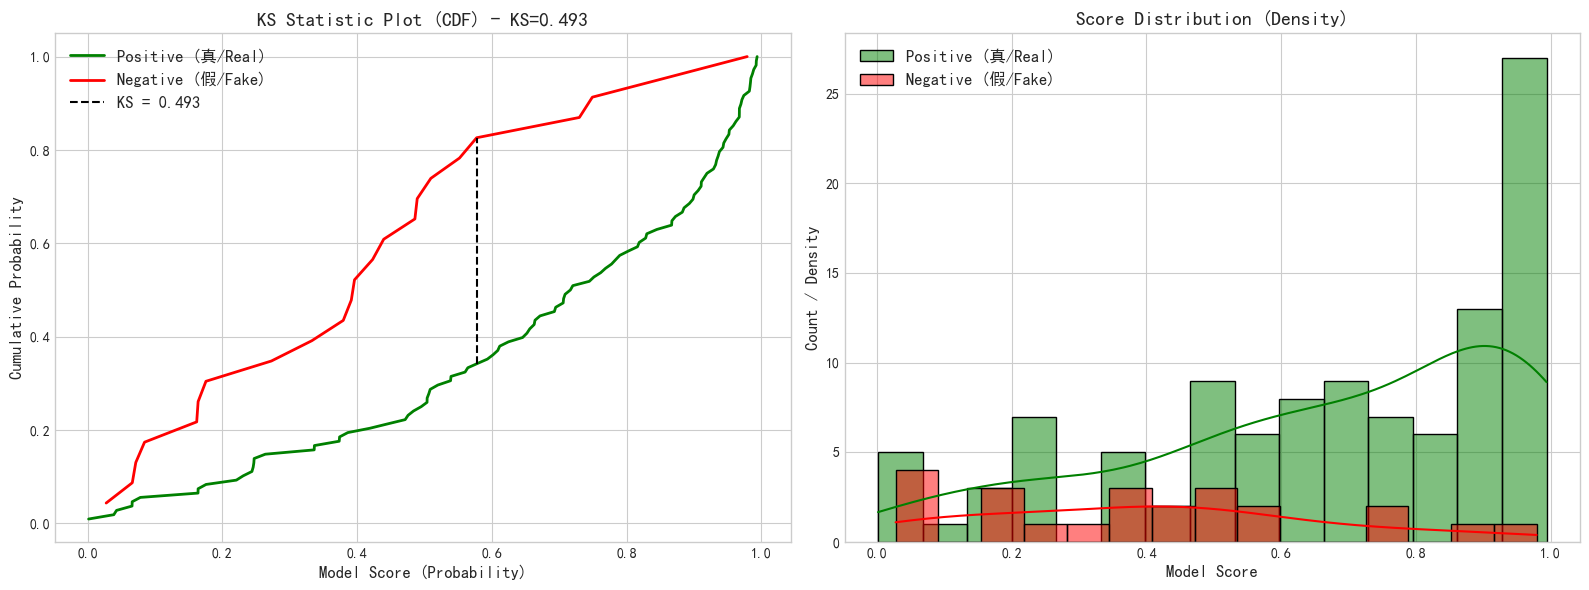

In [8]:

def plot_ks_and_hist(pos_scores, neg_scores, ks_value):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # --- 1. KS Plot (CDF) ---
    # 排序
    data_pos = np.sort(pos_scores)
    data_neg = np.sort(neg_scores)
    
    # 计算 CDF
    cdf_pos = np.arange(1, len(data_pos)+1) / len(data_pos)
    cdf_neg = np.arange(1, len(data_neg)+1) / len(data_neg)
    
    # 插值以寻找最大距离位置
    all_points = np.sort(np.concatenate([data_pos, data_neg]))
    cdf_pos_interp = np.interp(all_points, data_pos, cdf_pos, left=0, right=1)
    cdf_neg_interp = np.interp(all_points, data_neg, cdf_neg, left=0, right=1)
    diff = np.abs(cdf_pos_interp - cdf_neg_interp)
    max_diff_idx = np.argmax(diff)
    max_diff_x = all_points[max_diff_idx]
    
    # 绘制 CDF
    axes[0].plot(data_pos, cdf_pos, label='Positive (真/Real)', color='green', lw=2)
    axes[0].plot(data_neg, cdf_neg, label='Negative (假/Fake)', color='red', lw=2)
    
    # 绘制 KS 线
    axes[0].vlines(max_diff_x, 
                   ymin=min(cdf_pos_interp[max_diff_idx], cdf_neg_interp[max_diff_idx]),
                   ymax=max(cdf_pos_interp[max_diff_idx], cdf_neg_interp[max_diff_idx]), 
                   color='black', linestyle='--', label=f'KS = {ks_value:.3f}')
    
    axes[0].set_title(f'KS Statistic Plot (CDF) - KS={ks_value:.3f}', fontsize=14)
    axes[0].set_xlabel('Model Score (Probability)', fontsize=12)
    axes[0].set_ylabel('Cumulative Probability', fontsize=12)
    axes[0].legend(fontsize=12)
    
    # --- 2. Distribution Histogram ---
    sns.histplot(pos_scores, color='green', label='Positive (真/Real)', kde=True, ax=axes[1], alpha=0.5, bins=15)
    sns.histplot(neg_scores, color='red', label='Negative (假/Fake)', kde=True, ax=axes[1], alpha=0.5, bins=15)
    
    axes[1].set_title('Score Distribution (Density)', fontsize=14)
    axes[1].set_xlabel('Model Score', fontsize=12)
    axes[1].set_ylabel('Count / Density', fontsize=12)
    axes[1].legend(fontsize=12)
    
    plt.tight_layout()
    plt.savefig('model_verification_result.png', dpi=300)
    print("图表已保存为: model_verification_result.png")
    plt.show()

plot_ks_and_hist(pos_scores, neg_scores, ks_statistic)



## 4. 对用户图片进行打分 (Scoring User Images)
现在，我们将训练好的模型应用到目标数据集 (`2021MCM_ProblemC_Images_Files`)。
我们直接读取 `Image_Features_Scored.csv` 中的特征，计算新的概率得分。


In [9]:

target_csv = r"d:\wzm\python_math_model\Image_Features_Scored.csv"
output_csv = r"d:\wzm\python_math_model\New_Image_Scores_Prob.csv"

if os.path.exists(target_csv):
    print(f"Loading features from {target_csv}...")
    df_target = pd.read_csv(target_csv)
    
    # 确保列存在
    # 注意：这里假设 CSV 中的列名与训练时一致
    try:
        X_target = df_target[feature_cols].values
        
        # 预测概率
        target_scores = clf.predict_proba(X_target)[:, 1]
        
        # 保存结果
        df_target['New_Prob_Score'] = target_scores
        
        df_target.to_csv(output_csv, index=False)
        print(f"打分完成！结果已保存至: {output_csv}")
        print(df_target[['FileName', 'GlobalID', 'New_Prob_Score']].head())
    except KeyError as e:
        print(f"Error: 目标 CSV 中缺少必要的特征列: {e}")
        print("请先运行特征提取脚本。")
else:
    print("未找到目标 CSV 文件。请先运行 image_feature_extraction.py 提取特征。")


Loading features from d:\wzm\python_math_model\Image_Features_Scored.csv...
打分完成！结果已保存至: d:\wzm\python_math_model\New_Image_Scores_Prob.csv
                                           FileName  \
0  ATT1000_A5A50BAB-A6EF-4576-A1F8-A07862AADE3A.jpg   
1  ATT1001_8B9F8599-61EF-4690-B195-888BCD319F32.png   
2  ATT1002_7DFE65D0-B77A-4C7F-8849-685CEA02E862.jpg   
3                       ATT1003_20200718_151437.jpg   
4            ATT1004_Killer Hornet 2020-07-18 1.jpg   

                                 GlobalID  New_Prob_Score  
0  {E0AE2F2A-38A5-463C-97B5-9F84A477F9AE}        0.250476  
1  {1CD14B56-4046-44C4-B1B8-8FB07A9071E9}        0.170283  
2  {0C119F06-3578-4028-AA97-924CD22AAF51}        0.493041  
3  {52700FB3-ADBF-4EDE-BE99-9DF57E40E73F}        0.060810  
4  {1B521236-D295-4CFF-9677-A08EE988CA5D}        0.886186  
